In [ ]:
pip install matplotlib
pip install PyQt5
pip install numpy
pip install scipy

In [1]:
import numpy as np
import glob, os, copy
%matplotlib widget
import matplotlib.pyplot as plt
from scipy.ndimage.filters import gaussian_filter1d
plt.ion
np.set_printoptions(precision=2, suppress=True)

<ipython-input-1-67757f6be005>:5: DeprecationWarning: Please use `gaussian_filter1d` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter1d


In [2]:
# def check_validity(current_data_value, previous_average):
def check_diff_invalidity(current_data_value, previous_average):    
    epsilon = 0.75
    return not(np.linalg.norm(current_data_value - previous_average) <= epsilon)

def check_stat_invalidity(current_data_value, previous_average):
    epsilon = 1.0
    statistical_mean = np.array([3.45, -2.4, 0.75])
    return np.linalg.norm(current_data_value - statistical_mean) <= epsilon

def check_stat_and_diff_invalidity(current_data_value, previous_average, t, latest_valid_index):

    if latest_valid_index==-1:
        previous_average = current_data_value
            
    invalid = check_diff_invalidity(current_data_value, previous_average) or check_stat_invalidity(current_data_value, previous_average)

    return invalid
    
    # return check_diff_invalidity(current_data_value, previous_average) and check_stat_invalidity(current_data_value, previous_average)
    # return check_diff_invalidity(current_data_value, previous_average) or check_stat_invalidity(current_data_value, previous_average)

def filter_outliers(data):

    filter_size = 3
    # epsilon = 0.5 * np.ones(3)
    epsilon = 0.5
    alt_data = copy.deepcopy(data)
    averages = np.zeros_like(data)
    validity = np.ones(data.shape[0])
    latest_valid_index = -1

    # Initialize average.
    averages[0] = data[0]    

    print("Hello, about to start filtering.")    

	# Statistical mode check
    if check_stat_invalidity(alt_data[0], averages[0]):
        validity[0] = 0

    for k in range(1, data.shape[0]):
        
        # Check validity
        # If we think it's an outlying datapoint based on averages, rewrite the data to last valid data point, 
        # and set validity to 0. 
        # if not(check_diff_validity(alt_data[k], averages[k-1])):
        # if not(check_stat_validity(alt_data[k], averages[k-1])):   
        if check_stat_and_diff_invalidity(alt_data[k], averages[k-1], k, latest_valid_index):
            alt_data[k] = copy.deepcopy(alt_data[k-1])
            validity[k] = 0.
            # The average is now defined as the mean over the previous filter_size - 1 elements, and the current element.. 
            # averages[k] = alt_data[max(0, k+1-filter_size):k+1].mean(axis=0)
            averages[k] = alt_data[max(latest_valid_index, k+1-filter_size):k+1].mean(axis=0)
        else:            
            # Special case ofr us encountering the first valid data point afer a stream of invalid data points. 
            if latest_valid_index == -1:
                # Set average to current value.. 
                averages[k] = alt_data[k]
            else:
                # The average is now defined as the mean over the previous filter_size - 1 elements, and the current element.. 
                # averages[k] = alt_data[max(0, k+1-filter_size):k+1].mean(axis=0)
                averages[k] = alt_data[max(latest_valid_index, k+1-filter_size):k+1].mean(axis=0)

            # Set the last valid index to current timepoint. 
            latest_valid_index = k

        # print("#######################")
        # print("Filtering timestep: ", k)
        # print(data[k], averages[k-1], np.linalg.norm(data[k] - averages[k-1]))

        # The average is now defined as the mean over the previous filter_size - 1 elements, and the current element.. 
        # averages[k] = alt_data[max(0, k+1-filter_size):k+1].mean(axis=0)
    
    return averages, validity

In [3]:
def interpolate_position(valid=None, position_sequence=None):
	
	from scipy import interpolate
	
	# Interp1d from Scipy expects the last dimension to be the dimension we are ninterpolating over. 	
	valid_positions = np.swapaxes(position_sequence[valid==1], 1, 0)
	valid_times = np.where(valid==1)[0]
	query_times = np.arange(0, len(position_sequence))

	# Create interpolating function. 
	interpolating_function = interpolate.interp1d(valid_times, valid_positions)

	# Query interpolating function. 
	interpolated_positions = interpolating_function(query_times)

	# Swap axes back and return. 
	return np.swapaxes(interpolated_positions, 1, 0)

def interpolate_orientation(valid=None, orientation_sequence=None):

	from scipy.spatial.transform import Rotation as R
	from scipy.spatial.transform import Slerp

	valid_orientations = orientation_sequence[valid==1]
	rotation_sequence = R.concatenate(R.from_quat(valid_orientations))
	valid_times = np.where(valid==1)[0]
	query_times = np.arange(0, len(orientation_sequence))

	# Create slerp object. 
	slerp_object = Slerp(valid_times, rotation_sequence)

	# Query the slerp object. 
	interpolated_rotations = slerp_object(query_times)

	# Convert to quaternions.
	interpolated_quaternion_sequence = interpolated_rotations.as_quat()
	
	return interpolated_quaternion_sequence

def interpolate_valid_data(valid_data, validity):

    # Really this should follow the exact same pipeline as remaining dataloader stuff.. 
	# Last elements will always be valid. 
	# First may not be - backfill this. 

	# Phase 2.a : The first few elements may not be valid (here, the last elements always will be). 
	# If so, backfill first few elements with the first valid element. 
	first_valid_index = np.where(validity)[0][0]
	if first_valid_index>0:
		valid_data[:first_valid_index] = valid_data[first_valid_index]
		validity[:first_valid_index] = 1

	# Phase 2.b : Now that we have valid starts and ends, interpolate the data. 
	interpolated_data = interpolate_position(valid=validity, position_sequence=valid_data)
	
	return interpolated_data

In [4]:
# def old_process_data(data):

#     # Select Posiiton Data.
#     processed_data = data[1:, 10:13]
#     filtered_data, validity = filter_outliers(processed_data)
#     return filtered_data

def process_data(data):

    # Select Posiiton Data.
    processed_data = data[1:, 10:13]
    filtered_data, validity = filter_outliers(processed_data)
    # filtered_data = processed_data

    # Interpolate data - second phase 
    interpolated_data = interpolate_valid_data(filtered_data, validity)

    # Smoothen data
    kernel_bandwidth = 3
    smoothed_data = gaussian_filter1d(interpolated_data,kernel_bandwidth,axis=0,mode='nearest')

    # return filtered_data
    # return interpolated_data
    return smoothed_data

def plot_traj(original_data, processed_data=None):
    # plt.close()
    plt.figure()
    plt.plot(original_data)
    if processed_data is not None:
        plt.plot(processed_data, 'o', markersize=2)
    plt.show()

In [6]:
cd C:\Users\tshankar\Desktop\Research\Data\NDAX\dataset_prelim_2\dataset_prelim_2\

C:\Users\tshankar\Desktop\Research\Data\NDAX\dataset_prelim_2\dataset_prelim_2


In [15]:
ordered_joint_list = np.array(['gripper_state1', 'gripper_state2', 'gripper_state3',
    'gripper_state4', 'gripper_state5', 'gripper_state6',
    'orientation_w', 'orientation_w_elbow', 'orientation_w_object',
    'orientation_w_shoulder', 'orientation_x', 'orientation_x_elbow',
    'orientation_x_object', 'orientation_x_shoulder', 'orientation_y',
    'orientation_y_elbow', 'orientation_y_object',
    'orientation_y_shoulder', 'orientation_z', 'orientation_z_elbow',
    'orientation_z_object', 'orientation_z_shoulder', 'position_x',
    'position_x_elbow', 'position_x_object', 'position_x_shoulder',
    'position_y', 'position_y_elbow', 'position_y_object',
    'position_y_shoulder', 'position_z', 'position_z_elbow',
    'position_z_object', 'position_z_shoulder', 'stamp'], dtype='<U23')

for k, v in enumerate(ordered_joint_list):
    print(k,v)

0 gripper_state1
1 gripper_state2
2 gripper_state3
3 gripper_state4
4 gripper_state5
5 gripper_state6
6 orientation_w
7 orientation_w_elbow
8 orientation_w_object
9 orientation_w_shoulder
10 orientation_x
11 orientation_x_elbow
12 orientation_x_object
13 orientation_x_shoulder
14 orientation_y
15 orientation_y_elbow
16 orientation_y_object
17 orientation_y_shoulder
18 orientation_z
19 orientation_z_elbow
20 orientation_z_object
21 orientation_z_shoulder
22 position_x
23 position_x_elbow
24 position_x_object
25 position_x_shoulder
26 position_y
27 position_y_elbow
28 position_y_object
29 position_y_shoulder
30 position_z
31 position_z_elbow
32 position_z_object
33 position_z_shoulder
34 stamp


In [41]:
# ALL OF THESE ORIENTATIONS HAVE W FIRST. 
joint_index_dictionary = {}
# 
joint_index_dictionary['gripper_joints'] = np.arange(0,6)
# 
joint_index_dictionary['shoulder_position'] = np.array([25, 29, 33])
joint_index_dictionary['shoulder_orientation'] = np.array([9, 13, 17, 21])
#
joint_index_dictionary['elbow_position'] = np.array([23, 27, 31])
joint_index_dictionary['elbow_orientation'] = np.array([7, 11, 15, 19])
#
joint_index_dictionary['wrist_position'] = np.array([22, 26, 30])
joint_index_dictionary['wrist_orientation'] = np.array([6, 10, 14, 18])
#
joint_index_dictionary['object_position'] = np.array([24, 28, 32])
joint_index_dictionary['object_orientation'] = np.array([8, 12, 16, 20])

# ALL OF THESE ORIENTATIONS HAVE W LAST. 
joint_index_dictionary = {}
# 
joint_index_dictionary['gripper_joints'] = np.arange(0,6)
# 
joint_index_dictionary['shoulder_position'] = np.array([25, 29, 33])
joint_index_dictionary['shoulder_orientation'] = np.array([13, 17, 21, 9])
#
joint_index_dictionary['elbow_position'] = np.array([23, 27, 31])
joint_index_dictionary['elbow_orientation'] = np.array([11, 15, 19, 7])
#
joint_index_dictionary['wrist_position'] = np.array([22, 26, 30])
joint_index_dictionary['wrist_orientation'] = np.array([10, 14, 18, 6])
#
joint_index_dictionary['object_position'] = np.array([24, 28, 32])
joint_index_dictionary['object_orientation'] = np.array([12, 16, 20, 8])


In [ ]:
filelist = sorted(glob.glob("*.csv"))

for k,v in enumerate(filelist):

    # if not(v.startswith("stock_cupboard")):
    if True:
    
        print("################")
        print("Processing file: ", k, " , named: ", v)

        # Extract from file
        data = np.genfromtxt(v, delimiter=',')
        # process
        pdata = process_data(data)
        # plot
        plot_traj(data[1:, 10:13], pdata)

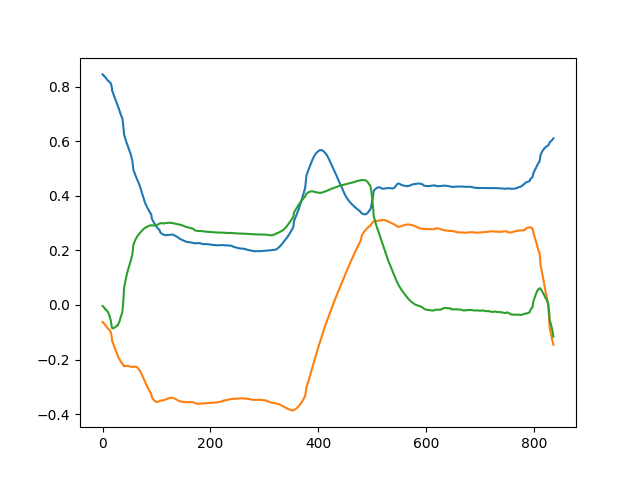

In [18]:
# data = np.genfromtxt('stock_cupboard_1.csv', delimiter=',')
data = np.genfromtxt('right_stocking_cupboard_1.csv', delimiter=',')
data2 = np.genfromtxt('right_stocking_cupboard_1.csv', delimiter=',', dtype='str')
# processed_data = data[1:, 10:13]
# filtered_data, validity = filter_outliers(processed_data)
wristpos = data[1:, joint_index_dictionary['wrist_position']]

plot_traj(wristpos)

In [29]:
filelist = sorted(glob.glob("right*.csv"))

for k,v in enumerate(filelist):

    # if not(v.startswith("stock_cupboard")):
    if True:
    
        print("################################")
        print("Processing file: ", k, " , named: ", v)

        # Extract from file
        data = np.genfromtxt(v, delimiter=',')
        # # process
        # pdata = process_data(data)
        # plot
        # plot_traj(data[1:, joint_index_dictionary['wrist_position']])
        # plot_traj(data[1:, joint_index_dictionary['elbow_position']])
        # plot_traj(data[1:, joint_index_dictionary['shoulder_position']])
        # plot_traj(data[1:, joint_index_dictionary['object_position']])
        # plot_traj(data[1:, joint_index_dictionary['object_position']], processed_data= data[1:, joint_index_dictionary['wrist_position']])

################################
Processing file:  0  , named:  right_closing_door_0.csv
################################
Processing file:  1  , named:  right_closing_door_1.csv
################################
Processing file:  2  , named:  right_closing_door_2.csv
################################
Processing file:  3  , named:  right_opening_door_0.csv
################################
Processing file:  4  , named:  right_opening_door_1.csv
################################
Processing file:  5  , named:  right_opening_door_2.csv
################################
Processing file:  6  , named:  right_stocking_cupboard_0.csv
################################
Processing file:  7  , named:  right_stocking_cupboard_1.csv
################################
Processing file:  8  , named:  right_stocking_cupboard_2.csv
################################
Processing file:  9  , named:  right_stocking_cupboard_box_0.csv
################################
Processing file:  10  , named:  right_stocking_cupboa

In [30]:
filelist

['right_closing_door_0.csv',
 'right_closing_door_1.csv',
 'right_closing_door_2.csv',
 'right_opening_door_0.csv',
 'right_opening_door_1.csv',
 'right_opening_door_2.csv',
 'right_stocking_cupboard_0.csv',
 'right_stocking_cupboard_1.csv',
 'right_stocking_cupboard_2.csv',
 'right_stocking_cupboard_box_0.csv',
 'right_stocking_cupboard_box_1.csv',
 'right_stocking_cupboard_box_2.csv',
 'right_stocking_cupboard_pringle_0.csv',
 'right_stocking_cupboard_pringle_1.csv',
 'right_stocking_cupboard_pringle_2.csv',
 'right_stocking_cupboard_spam_0.csv',
 'right_stocking_cupboard_spam_1.csv',
 'right_stocking_cupboard_spam_2.csv']

In [32]:
for k,v in joint_index_dictionary.items():
    print(k,v)

gripper_joints [0 1 2 3 4 5]
shoulder_position [25 29 33]
shoulder_orientation [ 9 13 17 21]
elbow_position [23 27 31]
elbow_orientation [ 8 11 15 19]
wrist_position [22 26 30]
wrist_orientation [ 6 10 14 18]
object_position [24 28 32]
object_orientation [ 8 12 16 20]


In [33]:
joint_index_dictionary.keys()

dict_keys(['gripper_joints', 'shoulder_position', 'shoulder_orientation', 'elbow_position', 'elbow_orientation', 'wrist_position', 'wrist_orientation', 'object_position', 'object_orientation'])